In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
import stan
import aesara.tensor as at
import nest_asyncio

from scipy.special import ndtri
from scipy.stats import norm, lognorm
from scipy.optimize import minimize

from sklearn.metrics import roc_auc_score

import time

from utils import stan_wrapper, stan_visualize_out, stan_predict, \
    pymc_wrapper, pymc_predict, MLS_wrapper, minimize_predict

In [2]:
FACTOR = 1/100
beta = 0.88

fname = 'results_raw.pickle'
# Create a writer object
file = open(fname, 'rb')
# dump information
results_decision = pickle.load(file)
# close file
file.close()

fname = 'results_raw_50.pickle'
# Create a writer object
file = open(fname, 'rb')
# dump information
results_decision_50 = pickle.load(file)
# close file
file.close()

fname = 'results_raw_25.pickle'
# Create a writer object
file = open(fname, 'rb')
# dump information
results_decision_25 = pickle.load(file)
# close file
file.close()

df_25 = pd.concat(results_decision_25, names=['subject'])
df_50 = pd.concat(results_decision_50, names=['subject'])

results_decision_50.keys()
df = results_decision_50['11112']

mu_theta, mu_Lambda, mu_tau, mu_alpha, mu_gamma = -1.32617141, 0.41613512, -1.37750916, -0.24550931, -0.13804112
sig_theta, sig_Lambda, sig_tau, sig_alpha, sig_gamma = 0.19484903, 0.71492692,  0.17975801, 0.08284753, 0.67868274
sig_error = 1.9222773
x0 = np.array([mu_theta, sig_theta, mu_Lambda, sig_Lambda, mu_tau, sig_tau, mu_alpha, sig_alpha, mu_gamma, sig_gamma, sig_error])

distro_estimates = {'mu':{'theta': x0[0], 'Lambda': x0[2], 'tau': x0[4], 'alpha': x0[6], 'gamma': x0[8]},
                         'sigma':{'theta': x0[1], 'Lambda': x0[3], 'tau': x0[5], 'alpha': x0[7],  'gamma': x0[9], 'error':x0[10]}}
distro_estimates_export = pd.DataFrame(distro_estimates)
distro_estimates_export['exp(mu)'] = np.exp(distro_estimates_export['mu'])
distro_estimates_export.to_csv('distro_estimates_errors_tau_repeat.csv')
distro_estimates_export


THETA_INIT = 0.42
LAMBDA_INIT = 1.6
TAU_INIT = .28
ALPHA_INIT = .9
GAMMA_INIT = .7
ERROR_INIT = 0


INIT_VALUES = np.array([THETA_INIT, LAMBDA_INIT, TAU_INIT, ALPHA_INIT, GAMMA_INIT, ERROR_INIT])

THETA_INIT, LAMBDA_INIT, TAU_INIT, ALPHA_INIT, GAMMA_INIT, ERROR_INIT = INIT_VALUES

In [75]:
df_50.head()


trial_num  response_time  invest  prob_win  prob_loss  prob_ambi  \
subject                                                                       
11112   0          1      13.293310     1.0       0.2        0.3        0.5   
        1          2       5.902034     0.0       0.2        0.0        0.8   
        2          3       7.698850     1.0       0.4        0.3        0.3   
        3          4      10.992664     0.0       0.5        0.0        0.5   
        4          5       7.219638     1.0       0.0        0.2        0.8   

              gain    loss  lottery_trial_num  group_responsibility  
subject                                                              
11112   0   7000.0 -3000.0               29.0                   0.0  
        1  10000.0 -6000.0               46.0                   0.0  
        2   4000.0 -2000.0               19.0                   0.0  
        3   3000.0 -7000.0                3.0                   0.0  
        4   5000.0 -1000.0               43.0                   0.0

In [4]:
# Stan
start_time  = time.time()
stan_fit    = stan_wrapper(df, x0, INIT_VALUES= INIT_VALUES,     FACTOR = FACTOR, beta=beta)
stan_time   = time.time() - start_time

if 0:
    stan_visualize_out(stan_fit, figure_flag=True)



Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   8% (600/8000)
Sampling:  16% (1300/8000)
Sampling:  26% (2100/8000)
Sampling:  50% (4000/8000)
Sampling:  71% (5700/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 10

/Users/administrator/MGME/Sandbox/bayesian optimization/utils.py:336: RuntimeWarning: invalid value encountered in power
  return at.switch(x >= 0, x**alpha, -Lambda * (-x)**beta)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, Lambda, tau, alpha, gamma, error]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 12633 seconds.


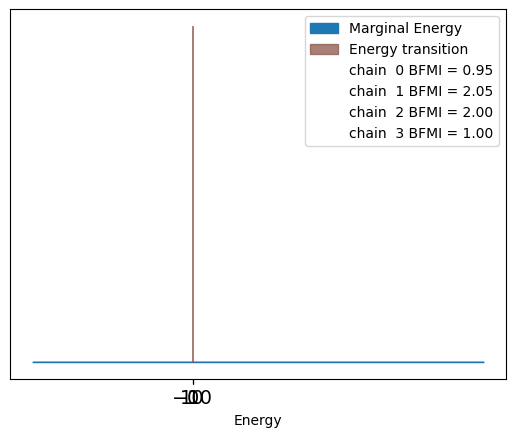

X axis values (energy):
[33.67680141 34.97948608 34.19686269 ... 37.31780408 36.63326256
 37.17013387]


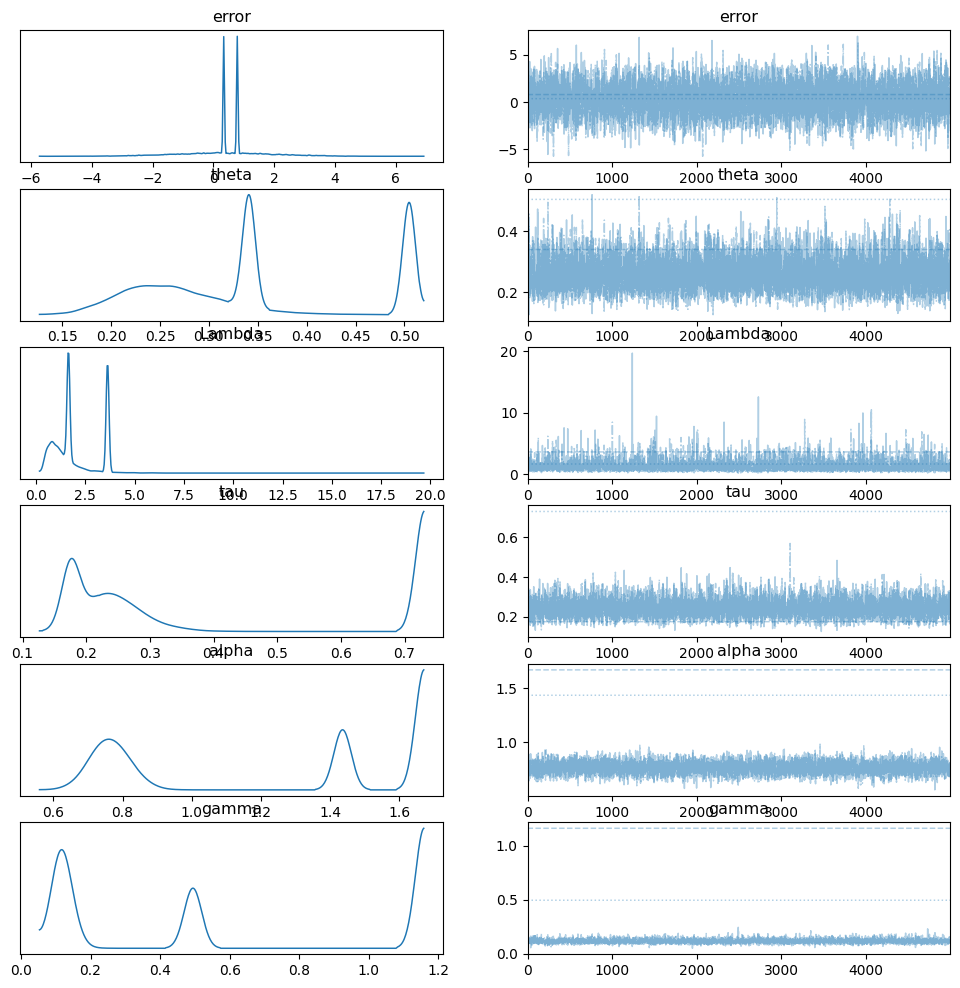

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta   0.341  0.106   0.202    0.505      0.050    0.023       5.0     104.0   
Lambda  1.975  1.160   0.522    3.602      0.481    0.193       8.0     101.0   
tau     0.349  0.225   0.176    0.731      0.111    0.062       5.0       4.0   
alpha   1.159  0.406   0.702    1.672      0.202    0.041       5.0      96.0   
gamma   0.473  0.425   0.099    1.159      0.212    0.103       5.0     111.0   
error   0.458  1.219  -2.463    2.869      0.051    0.294      54.0      99.0   

        r_hat  
theta    2.32  
Lambda   2.37  
tau      2.24  
alpha    2.29  
gamma    3.41  
error    1.75  
PyMC fitting time: 12649.21 seconds


In [5]:
# Pymc
start_time_pymc = time.time()

trace = pymc_wrapper(df, distro_estimates, INIT_VALUES, FACTOR=1, beta=0.88, energy_plot_flag=True, distri_plot_flag=True)

pymc_time = time.time() - start_time_pymc
print(f"PyMC fitting time: {pymc_time:.2f} seconds")

In [8]:

# MLS
start_time_MLS  = time.time()
estimates       = MLS_wrapper(df, INIT_VALUES, distro_estimates)
time_MLS        = time.time() - start_time_MLS



Optimization terminated successfully.
         Current function value: 17.710697
         Iterations: 921
         Function evaluations: 1506


In [9]:
#evaluation
# 
stan_predictions = stan_predict(stan_fit, df, FACTOR=FACTOR)
pymc_predictions = pymc_predict(trace, df, FACTOR=FACTOR, beta=0.88)
MLS_predictions  = minimize_predict(estimates, df, FACTOR=FACTOR, beta=0.88)


# Calculate ROC AUC performance

y_true = df['invest'].values
y_pred = np.array(stan_predictions)

roc_auc_stan    = roc_auc_score(y_true, y_score = np.array(stan_predictions))
roc_auc_pymc    = roc_auc_score(y_true, y_score = np.array(pymc_predictions))
roc_auc_MLS     = roc_auc_score(y_true, y_score = np.array(MLS_predictions))


print(f"Stan fitting time: {stan_time:.2f} seconds")
print(f"PyMC fitting time: {pymc_time:.2f} seconds")
print(f"MLS fitting time: {time_MLS:.2f} seconds")
print(f"ROC AUC: {roc_auc_stan:.4f} (Stan), {roc_auc_MLS:.4f} (PyMC), {roc_auc_MLS:.4f} (minimize)")

Stan fitting time: 3.65 seconds
PyMC fitting time: 12649.21 seconds
MLS fitting time: 5.56 seconds
ROC AUC: 0.7083 (Stan), 0.6726 (PyMC), 0.6726 (minimize)


In [43]:
from IPython.display import clear_output

# Prepare a DataFrame to store AUC scores and fitting times for each subject
subjects = df_50.index.get_level_values(0).unique()
auc_results = pd.DataFrame(
    index=subjects,
    columns=[
        'roc_auc_stan', 
        # 'roc_auc_pymc', 
        'roc_auc_MLS',
        'stan_time', 
        # 'pymc_time', 
        'MLS_time'
    ]
)
params_stan = pd.DataFrame()
params_MLS = pd.DataFrame()


subj_counter = 1
for subject in subjects:
    clear_output(wait=True)
    print(f"Processing subject {subj_counter}/{len(subjects)}...")
    df_subj = df_50.loc[subject].copy()
    df_subj['invest'] = df_subj['invest'].astype(int)

    # Stan
    start_time_stan = time.time()
    stan_fit_subj   = stan_wrapper(df_subj, x0, INIT_VALUES=INIT_VALUES, FACTOR=FACTOR, beta=beta)
    stan_time_subj  = time.time() - start_time_stan
    stan_pred       = stan_predict(stan_fit_subj, df_subj, FACTOR=FACTOR)
    stan_params_subj = {
        'subject': subject,
        'theta': stan_fit_subj.to_frame()['theta'].mean(),
        'Lambda': stan_fit_subj.to_frame()['Lambda'].mean(),
        'alpha': stan_fit_subj.to_frame()['alpha'].mean(),
        'tau': stan_fit_subj.to_frame()['tau'].mean(),
        'beta': 0.88,  # already defined as 0.88
        'gamma': stan_fit_subj.to_frame()['gamma'].mean(),
        'error': stan_fit_subj.to_frame()['error'].mean()
    }

    params_stan = pd.concat([params_stan, pd.DataFrame(stan_params_subj, index=[0])], axis=0)
    
    clear_output(wait=True)

    # # PyMC
    # start_time_pymc = time.time()
    # trace_subj = pymc_wrapper(df_subj, distro_estimates, INIT_VALUES, FACTOR=FACTOR, beta=beta, energy_plot_flag=False, distri_plot_flag=False)
    # pymc_time_subj = time.time() - start_time_pymc
    # pymc_pred = pymc_predict(trace_subj, df_subj, FACTOR=FACTOR, beta=beta)

    # MLS
    start_time_MLS = time.time()
    estimates_subj = MLS_wrapper(df_subj, INIT_VALUES, distro_estimates)
    MLS_time_subj  = time.time() - start_time_MLS
    MLS_pred       = minimize_predict(estimates_subj, df_subj, FACTOR=FACTOR, beta=beta)
    theta, Lambda, tau, alpha, gamma, error = estimates_subj.x
    MLS_params_subj = {
        'subject': subject,
        'theta': theta,
        'Lambda': Lambda,
        'alpha': alpha,
        'tau': tau,
        'beta': 0.88,  # already defined as 0.88
        'gamma': gamma,
        'error': error
    }
    params_MLS = pd.concat([params_MLS, pd.DataFrame(MLS_params_subj, index=[0])], axis=0)                           
    y_true_subj = df_subj['invest'].values

    auc_results.loc[subject, 'roc_auc_stan'] = roc_auc_score(y_true_subj, stan_pred)
    # auc_results.loc[subject, 'roc_auc_pymc'] = roc_auc_score(y_true_subj, pymc_pred)
    auc_results.loc[subject, 'roc_auc_MLS'] = roc_auc_score(y_true_subj, MLS_pred)
    auc_results.loc[subject, 'stan_time'] = stan_time_subj
    # auc_results.loc[subject, 'pymc_time'] = pymc_time_subj
    auc_results.loc[subject, 'MLS_time'] = MLS_time_subj
    
    subj_counter += 1
    
auc_results.to_csv('auc_results_by_subject.csv')
auc_results


Optimization terminated successfully.
         Current function value: 27.661243
         Iterations: 686
         Function evaluations: 1140


,roc_auc_stan,roc_auc_MLS,stan_time,MLS_time
subject,,,,
11112,0.708333,0.672619,3.771301,5.267784
111,0.751838,0.753676,4.572955,11.564654
14,0.526738,0.585561,3.241346,5.272011
18670,0.6,0.62,3.356205,3.171793
1970,0.733512,0.719251,3.837561,4.383407
2301,0.752381,0.77619,2.848279,8.274859
24574,0.640068,0.678268,3.456052,3.45042
24614,0.845515,0.833887,2.612535,5.882109
24683,0.747029,0.79966,2.793037,4.236518


In [44]:
auc_results

,roc_auc_stan,roc_auc_MLS,stan_time,MLS_time
subject,,,,
11112,0.708333,0.672619,3.771301,5.267784
111,0.751838,0.753676,4.572955,11.564654
14,0.526738,0.585561,3.241346,5.272011
18670,0.6,0.62,3.356205,3.171793
1970,0.733512,0.719251,3.837561,4.383407
2301,0.752381,0.77619,2.848279,8.274859
24574,0.640068,0.678268,3.456052,3.45042
24614,0.845515,0.833887,2.612535,5.882109
24683,0.747029,0.79966,2.793037,4.236518


In [39]:
auc_results.mean()

roc_auc_stan    0.686939
roc_auc_MLS     0.703907
stan_time       3.506538
MLS_time         6.33832
dtype: object

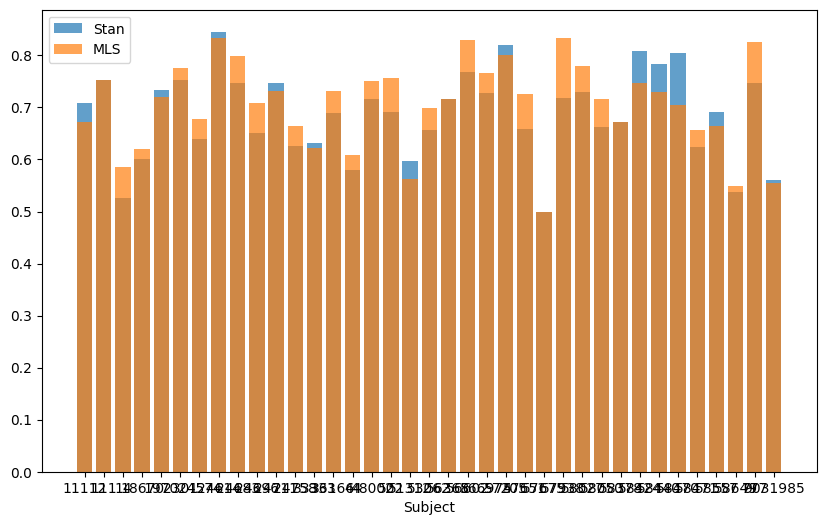

In [54]:
plt.figure(figsize=(10, 6))
plt.bar(auc_results.index, auc_results['roc_auc_stan'], label='Stan', alpha=0.7)
plt.bar(auc_results.index, auc_results['roc_auc_MLS'], label='MLS', alpha=0.7)
plt.xlabel('Subject')   
plt.legend()

In [56]:
params_stan.describe()

params_MLS.describe()

plt.figure(figsize=(10, 6))
params_to_plot = ['theta', 'Lambda', 'alpha', 'tau', 'gamma', 'error']
# Combine parameters into a long-form DataFrame for grouped boxplots
params_stan_long = params_stan[params_to_plot].melt(var_name='Parameter', value_name='Value')
params_stan_long['Method'] = 'Stan'
params_MLS_long = params_MLS[params_to_plot].melt(var_name='Parameter', value_name='Value')
params_MLS_long['Method'] = 'MLS'
params_long = pd.concat([params_stan_long, params_MLS_long], ignore_index=True)

# Plot grouped boxplots for each parameter

# import seaborn as sns
# sns.violinplot(x='Parameter', y='Value', hue='Method', data=params_long, inner=None, cut=0)
# # Overlay the single point (since all values are the same per method/parameter)
# for i, param in enumerate(params_to_plot):
#     for j, method in enumerate(['Stan', 'MLS']):
#         # Get the unique value for this parameter/method
#         val = params_long[(params_long['Parameter'] == param) & (params_long['Method'] == method)]['Value'].iloc[0]
#         # Offset the x position for Stan and MLS
#         x_pos = i - 0.2 if method == 'Stan' else i + 0.2
#         plt.scatter(x_pos, val, color='k', zorder=10, s=60, marker='o', edgecolor='white')
# plt.ylabel('Parameter Value')
# plt.title('Boxplot of Parameters: Stan vs MLS')
plt.show()

<Figure size 1000x600 with 0 Axes>

In [53]:
params_stan.describe()


,theta,Lambda,alpha,tau,beta,gamma,error
count,37.000000,37.000000,37.000000,37.000000,3.700000e+01,37.000000,37.000000
mean,0.277879,1.092181,0.795985,0.252896,8.800000e-01,1.282191,0.312399
std,0.028777,0.459618,0.034781,0.015828,1.125537e-16,0.921483,0.826459
min,0.229900,0.508600,0.726139,0.219742,8.800000e-01,0.253833,-1.891098
25%,0.254670,0.783824,0.776421,0.246187,8.800000e-01,0.558050,-0.085766
50%,0.276874,1.064834,0.798624,0.255594,8.800000e-01,0.778554,0.367258
75%,0.296820,1.226446,0.814614,0.262865,8.800000e-01,2.055143,0.958501
max,0.362417,2.985267,0.863039,0.276774,8.800000e-01,3.194973,1.945794


/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_6306/3037836496.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[0], positions=positions - width/2, widths=0.3, patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'), labels=params_to_plot)


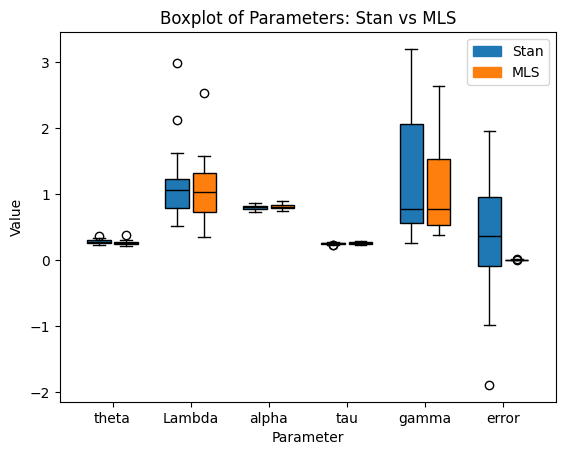

In [ ]:
from matplotlib.patches import Patch

params_to_plot = ['theta', 'Lambda', 'alpha', 'tau', 'gamma', 'error']

# Prepare data for boxplot
data = [
    params_stan[params_to_plot].values,
    params_MLS[params_to_plot].values
]
 
# Create positions for the boxplots
positions = np.arange(len(params_to_plot))
width = 0.35

# Stan boxplots
plt.boxplot(data[0], positions=positions - width/2, widths=0.3, patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'), labels=params_to_plot)
plt.boxplot(data[1], positions=positions + width/2, widths=0.3, patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'))
plt.xticks(positions, params_to_plot)

plt.xlabel('Parameter')
plt.ylabel('Value')
plt.title('Boxplot of Parameters: Stan vs MLS')

# Add manual legend
stan_patch = Patch(color='C0', label='Stan')
mls_patch = Patch(color='C1', label='MLS')
plt.legend(handles=[stan_patch, mls_patch])

plt.show()